In [3]:
import numpy as np
import pandas as pd
import librosa
import json
import os
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Setting the DataFrame and extracting the audio path and JSON metadata

In [4]:
# setting the dataset folder
folder_path = r"../public_dataset"

# Creating lists to store the files

files = []
cough_scores = []
timestamps = []

# loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".wav"):
        # store the wav file path
        wav_path = os.path.join(folder_path, file_name)
        files.append(wav_path)

        # Get the corresponding JSON file 
        json_name = file_name.replace(".wav", ".json")
        json_path = os.path.join(folder_path, json_name)

        # Read the labels from the JSON
        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                # store the json data in the data dictionary
                data = json.load(f)

                cough_scores.append(float(data["cough_detected"]))
                timestamps.append(data["datetime"])
        else:
            cough_scores.append(0.0)
            timestamps.append("unknown")
            
# Creating the dataframe
df = pd.DataFrame({
    "file_path" : files,
    "cough_confidence" : cough_scores,
    "timestamp" : timestamps
})

df.head()

,file_path,cough_confidence,timestamp
0,../public_dataset\2d1d8b3f-4bfc-4bbd-b32e-1a03...,0.0000,unknown
1,../public_dataset\2d22665d-5ca0-47f1-80ad-ebfa...,0.8796,2020-08-19T18:12:19.693957+00:00
2,../public_dataset\2d25616a-2bee-492e-a3ff-7c20...,0.0099,2020-04-14T18:37:54.848372+00:00
3,../public_dataset\2d26833b-337e-4d31-b566-f0d2...,0.9817,2020-05-18T19:56:19.359410+00:00
4,../public_dataset\2d28744c-a394-438b-8999-0542...,0.8822,2020-04-14T15:04:24.762414+00:00


In [5]:
def extract_mfcc_2d(wav_path,
                    sr = 16000,
                    n_mfcc = 40,
                    n_mels = 128,
                    n_fft = 1024, 
                    hop_length = 512, 
                    duration = None, 
                    max_frames = None,
                    normalise = True
                   ):
    """
    We Extract 2D MFCC (time x n_mfcc) from a wav file.

    Parameters:
    - wav_path: path to the .wav file
    - sr: target sample rate
    - n_mfcc: number of mfccs coefficient to be extracted
    - n_fft: FFT window size (samples per each frame)
    - hop_length: hop length(samples) between frames
    """
    if duration is not None:
        target_samples = int(sr * duration)
        y, _ = librosa.load(wav_path, sr = sr, mono = True, duration = duration)
        if len(y) < target_samples:
             y = np.pad(y, (0, target_samples - len(y)), mode='constant')
        elif len(y) > target_samples:
            y = y[:target_samples]
    else:
        y, _ = librosa.load(wav_path, sr = sr, mono = True)

    # (n_features, n_frames)
    mfcc = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc, n_mels = n_mels,
                                n_fft = n_fft, hop_length = hop_length,
                                center = True, htk = False)

    if normalise:
        eps = 1e-9
        mean = np.mean(mfcc, axis = 1, keepdims = True)
        std = np.std(mfcc, axis = 1, keepdims = True)
        mfcc = (mfcc - mean) / (std + eps)

    # Transpose to (time_frames, n_features)                            
    mfcc = mfcc.T  # shape: (n_frames, n_features)
    
    if max_frames is not None:
        T, F = mfcc.shape
        if T < max_frames:
            pad_width = ((0, max_frames - T), (0, 0))
            mfcc = np.pad(mfcc, pad_width=pad_width, mode='constant', constant_values=0.0)
        elif T > max_frames:
            mfcc = mfcc[:max_frames, :] 

    return mfcc

In [6]:
def extract_features(df,
                     duration = 9,
                     sr = 16000,
                     n_mfcc = 40,
                     n_mels = 128,
                     n_fft = 1024, 
                     hop_length = 512,
                     normalise = True,
                    ):
    target_samples = int( sr * duration)
    expected_frames = 1 + int(np.floor((target_samples - n_fft) / float(hop_length))) if target_samples > n_fft else 1
    
    n_files = len(df)
    X = np.zeros((n_files, expected_frames, n_mfcc), dtype = np.float32)
    y = (df["cough_confidence"] >= 0.5).astype(np.float32).values

    for i, wav_path in enumerate(tqdm(df["file_path"], desc = "Extracting MFCCs")):
        try:
            mfcc = extract_mfcc_2d(
                wav_path,
                sr = sr,
                n_mfcc = n_mfcc,
                n_mels = n_mels,
                n_fft = n_fft,
                hop_length = hop_length,
                duration = duration,
                max_frames=expected_frames,
                normalise = normalise
            )
            X[i] = mfcc
        except Exception as e:
            print(f"Warning: failed to process {wav_path}: {e}")

    return X, y

X, y = extract_features(df, duration = 9.0)

Extracting MFCCs:   0%|          | 0/22771 [00:00<?, ?it/s]

Extracting MFCCs: 100%|██████████| 22771/22771 [08:47<00:00, 43.14it/s] 


In [7]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(f"\nClass distribution:")

print(f"Cough samples (1): {np.sum(y == 1)}")
print(f"Non-cough samples (0): {np.sum(y == 0)}")

X shape: (22771, 280, 40)
y shape: (22771,)

Class distribution:
Cough samples (1): 15041
Non-cough samples (0): 7730


In [8]:

print('Version:', tf.__version__); print('GPU Available:', len(tf.config.list_physical_devices('GPU')) > 0)

Version: 2.10.0
GPU Available: True


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"validating set: {X_val.shape}")



Training set: (14572, 280, 40)
Test set: (4555, 280, 40)
validating set: (3644, 280, 40)


In [10]:
def time_shift(mfcc, max_shift=10):
    """Randomly roll MFCCs along time axis (frame shift)."""
    shift = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
    return tf.roll(mfcc, shift=shift, axis=0)


def add_noise(mfcc, noise_level=0.02):
    """Add small Gaussian noise without changing shape or scaling."""
    noise = tf.random.normal(tf.shape(mfcc), stddev=noise_level)
    return mfcc + noise


def random_gain(mfcc, min_gain=0.8, max_gain=1.2):
    """Apply a random global gain (volume-like scaling)."""
    gain = tf.random.uniform([], min_gain, max_gain)
    return mfcc * gain


def augment_mfcc(mfcc, label):
    """Apply lightweight augmentations for training only.

    Keeps the (time, n_mfcc) shape identical so the model
    and Arduino preprocessing pipeline remain unchanged.
    """
    # Random small time shift
    if tf.random.uniform([]) < 0.5:
        mfcc = time_shift(mfcc, max_shift=10)

    # Random gain
    if tf.random.uniform([]) < 0.5:
        mfcc = random_gain(mfcc, min_gain=0.9, max_gain=1.1)

    # Always add a bit of noise
    mfcc = add_noise(mfcc, noise_level=0.01)

    return mfcc, label


In [11]:
# def augment_mfcc(mfcc, label):
#     mfcc = time_shift(mfcc)
#     mfcc = add_noise(mfcc)
#     mfcc = random_gain(mfcc)

#     if tf.random.uniform([]) < 0.5:
#         mfcc = spec_augment(mfcc)

#     return mfcc, label

# train_ds = train_ds.map(augment_mfcc, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
y_train_onehot = to_categorical(y_train, num_classes=2)
y_val_onehot   = to_categorical(y_val,   num_classes=2)
y_test_onehot  = to_categorical(y_test,  num_classes=2)

print(f"Training set: {y_train_onehot.shape}")
print(f"Validation set: {y_val_onehot.shape}")
print(f"Test set: {y_test_onehot.shape}")

Training set: (14572, 2)
Validation set: (3644, 2)
Test set: (4555, 2)


In [13]:
def build_tinyml_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)

    x = tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)

    x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cough_cnn")
    return model


In [14]:
def compile_model(model, learning_rate = 3e-4):
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy",
                 keras.metrics.Precision(name="Precision"),
                 keras.metrics.Recall(name="recall")]
    )
    return model

In [15]:
print(f"2. Final training data shape for model.fit: {X_train.shape}")

2. Final training data shape for model.fit: (14572, 280, 40)


In [16]:
def train_model(model,
                X_train, y_train_onehot,
                X_val, y_val_onehot,
                class_weight=None,
                batch_size=16,
                epochs=50,
                save_path=None):

    with tf.device('/cpu:0'):
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot))
        train_dataset = train_dataset.shuffle(buffer_size=1024)

        # Apply augmentation ONLY on the training dataset.
        # This operates on already-extracted MFCCs, so the
        # input shape (280, 40) and preprocessing pipeline
        # used on Arduino stay exactly the same.
        train_dataset = train_dataset.map(
            augment_mfcc,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        train_dataset = train_dataset.batch(batch_size)
        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

        # Validation set is kept clean (no augmentation)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_onehot))
        val_dataset = val_dataset.batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=4,
            min_lr=1e-6)
    ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )

    if save_path:
        model.save(save_path)
        print(f"Model saved to: {save_path}")

    return history

In [17]:
print(f"2. Final training data shape for model.fit: {X_train.shape}")

2. Final training data shape for model.fit: (14572, 280, 40)


In [18]:
input_shape = X_train.shape[1:]
model = build_tinyml_cnn(input_shape=input_shape)
compile_model(model, learning_rate=3e-4)
history = train_model(model,
                      X_train, y_train_onehot,
                      X_val, y_val_onehot,
                      batch_size=32,
                      epochs=50,
                      save_path="cough_cnn1.h5")     

Epoch 1/50
456/456 [==============================] - 36s 43ms/step - loss: 0.5142 - accuracy: 0.7869 - Precision: 0.7869 - recall: 0.7869 - val_loss: 0.4325 - val_accuracy: 0.8444 - val_Precision: 0.8444 - val_recall: 0.8444 - lr: 3.0000e-04
Epoch 2/50
456/456 [==============================] - 19s 41ms/step - loss: 0.4367 - accuracy: 0.8550 - Precision: 0.8550 - recall: 0.8550 - val_loss: 0.4047 - val_accuracy: 0.8620 - val_Precision: 0.8620 - val_recall: 0.8620 - lr: 3.0000e-04
Epoch 3/50
456/456 [==============================] - 19s 41ms/step - loss: 0.4099 - accuracy: 0.8738 - Precision: 0.8738 - recall: 0.8738 - val_loss: 0.3916 - val_accuracy: 0.8724 - val_Precision: 0.8724 - val_recall: 0.8724 - lr: 3.0000e-04
Epoch 4/50
456/456 [==============================] - 19s 41ms/step - loss: 0.3960 - accuracy: 0.8848 - Precision: 0.8848 - recall: 0.8848 - val_loss: 0.3822 - val_accuracy: 0.8845 - val_Precision: 0.8845 - val_recall: 0.8845 - lr: 3.0000e-04
Epoch 5/50
456/456 [========

In [19]:
def evaluate_model(model, X_test, y_test_onehot, y_test_labels, batch_size=32, show_report=True):
    """Forces evaluation onto CPU to avoid GPU memory issues."""
    
    # 1. Force TensorFlow operations to CPU
    with tf.device('/cpu:0'):
        # Create dataset on CPU
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot))
        test_dataset = test_dataset.batch(batch_size)
        
        # Move model weights to CPU temporarily
        with tf.device('/cpu:0'):
            # Evaluate
            eval_metrics = model.evaluate(test_dataset, verbose=0)
            print("Evaluation (loss, accuracy, precision, recall):", eval_metrics)
            
            # Predict
            y_pred_prob = model.predict(test_dataset, verbose=0)
    
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    if show_report:
        print("\nClassification report:")
        print(classification_report(y_test_labels, y_pred, digits=4))
        print("Confusion matrix:")
        print(confusion_matrix(y_test_labels, y_pred))

    return eval_metrics, y_pred

In [20]:
eval_metrics, y_pred = evaluate_model(model, X_test, y_test_onehot, y_test)

Evaluation (loss, accuracy, precision, recall): [0.37741321325302124, 0.885400652885437, 0.885400652885437, 0.885400652885437]

Classification report:
              precision    recall  f1-score   support

         0.0     0.8432    0.8137    0.8282      1546
         1.0     0.9060    0.9222    0.9140      3009

    accuracy                         0.8854      4555
   macro avg     0.8746    0.8680    0.8711      4555
weighted avg     0.8847    0.8854    0.8849      4555

Confusion matrix:
[[1258  288]
 [ 234 2775]]


In [21]:
def get_file_size(file_path):
    """Get file size in bytes"""
    return os.path.getsize(file_path)

def convert_bytes(bytes_size, unit):
    """Convert bytes to specified unit (KB, MB, GB)"""
    units = {"KB": 1024, "MB": 1024**2, "GB": 1024**3}
    return bytes_size / units[unit]

# Now use it
file_size_mb = convert_bytes(get_file_size("cough_cnn1.h5"), "MB")
print(f"Model size: {file_size_mb:.2f} MB")

Model size: 0.55 MB


In [22]:
import numpy as np

# Suppose your X_train is already loaded in memory
np.save("X_train.npy", X_train)
print("X_train saved as X_train.npy")


X_train saved as X_train.npy


In [23]:
import tensorflow as tf
import numpy as np
import os

model = tf.keras.models.load_model("cough_cnn1.h5")
print("Keras input shape:", model.input_shape) 
print("Keras output shape:", model.output_shape)
print("Keras dtype:", model.dtype)

# --- Representative generator using model.input_shape ---
input_shape = model.input_shape  # tuple (None, dim1, dim2?) etc
# create a safe generator that uses X_train (you already have X_train)
def representative_data_gen():
    for i in range(100):
        sample = X_train[i].astype(np.float32)
        # Ensure sample includes batch dimension
        if sample.ndim == len(input_shape) - 1:
            sample = sample.reshape((1,) + sample.shape)
        elif sample.ndim == len(input_shape):
            sample = sample.reshape((1,) + sample.shape[1:])
        yield [sample]

# Convert to TFLite INT8 (FULL integer quantization, INT8 I/O)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
open("cough_cnn1_int8.tflite","wb").write(tflite_model)
print("Wrote cough_cnn1_int8.tflite (size KB):", os.path.getsize("cough_cnn1_int8.tflite")/1024)


Keras input shape: (None, 280, 40)
Keras output shape: (None, 2)
Keras dtype: float32


INFO:tensorflow:Assets written to: C:\Users\Aman\AppData\Local\Temp\tmp67t80qym\assets


INFO:tensorflow:Assets written to: C:\Users\Aman\AppData\Local\Temp\tmp67t80qym\assets
c:\Users\Aman\anaconda3\envs\tf_gpu_final\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Wrote cough_cnn1_int8.tflite (size KB): 57.734375


In [24]:
interpreter = tf.lite.Interpreter(model_path="cough_cnn1_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print("Input shape:", input_details["shape"])
print("Input quantization:", input_details["quantization"])   # (scale, zero_point)
print("Output shape:", output_details["shape"])
print("Output quantization:", output_details["quantization"]) # (scale, zero_point)
print("Output dtype:", output_details["dtype"])


Input shape: [  1 280  40]
Input quantization: (0.13141827285289764, -1)
Output shape: [1 2]
Output quantization: (0.00390625, -128)
Output dtype: <class 'numpy.int8'>


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1258  288]
 [ 234 2775]]


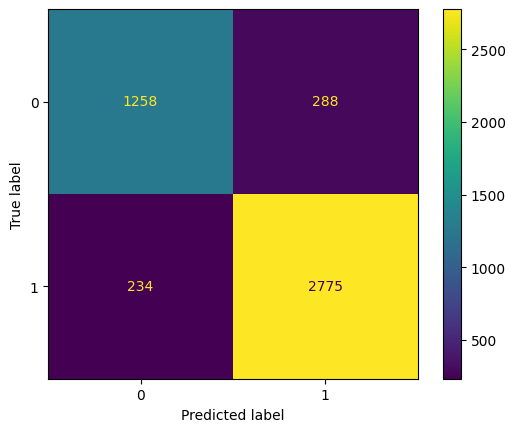

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();